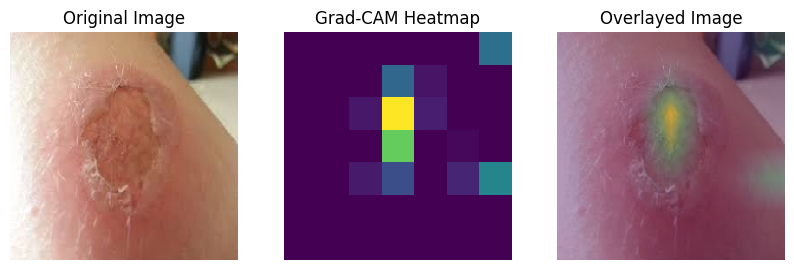

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model

model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=True)

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img, img_array

def grad_cam(input_model, img_array, layer_name="block6a_activation"):
    grad_model = Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap_resized = tf.image.resize(heatmap, (img.size[1], img.size[0])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized)
    colormap = plt.cm.viridis(heatmap_resized / 255.0)[:, :, :3] * 255
    colormap = np.uint8(colormap)
    overlayed_img = np.array(img) * (1 - alpha) + colormap * alpha
    overlayed_img = np.uint8(overlayed_img)
    return overlayed_img

test_image_path = "/kaggle/input/xai-data/images.jpg"
original_img, processed_img = preprocess_image(test_image_path)
heatmap = grad_cam(model, processed_img)
overlayed_img = overlay_heatmap(original_img, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='viridis')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Overlayed Image")
plt.imshow(overlayed_img)
plt.axis('off')
plt.show()
